In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN, KMeans
import optuna


In [2]:
# data_types = {14: str, 46: str, 78: str} 
df = pd.read_csv('../../data/embf_merged.csv')
# df.drop(['Unnamed: 0'], axis=1, inplace=True)


In [3]:
df.head()

,EIN,NAME,ICO,STREET,CITY,STATE,ZIP,GROUP,SUBSECTION,AFFILIATION,...,ASSET_CD,INCOME_CD,FILING_REQ_CD,PF_FILING_REQ_CD,ACCT_PD,ASSET_AMT,INCOME_AMT,REVENUE_AMT,NTEE_CD,SORT_NAME
0,4101,SOUTH LAFOURCHE QUARTERBACK CLUB,NaN,167 BENT CYPRESS LN,LOCKPORT,LA,70374-4284,0,3,3,...,0,0,0,1,12,NaN,NaN,NaN,N65,NaN
1,260049,CORINTH BAPTIST CHURCH,NaN,PO BOX 92,HOSFORD,FL,32334-0092,2024,3,9,...,0,0,6,0,12,NaN,NaN,NaN,NaN,NaN
2,360268,IGLESIA VICTORIA,NaN,1445 N BOONVILLE AVE,SPRINGFIELD,MO,65802-1894,1678,3,9,...,0,0,6,0,12,NaN,NaN,NaN,NaN,NaN
3,490336,EASTSIDE BAPTIST CHURCH,NaN,PO BOX 296,LABELLE,FL,33975-0296,2024,3,9,...,0,0,6,0,12,NaN,NaN,NaN,NaN,NaN
4,2296179,RELIGIOUS SCIENCE CHURCH CENTER OF SAN DIEGO,NaN,4102 MARLBOROUGH,SAN DIEGO,CA,92105-1462,0,3,3,...,0,0,6,0,3,NaN,NaN,NaN,NaN,NaN


# Cities Facing Digital Divide and Climate Change

In [4]:
# specify cities targeted for analysis (from Noha analysis)
dd_cc_cities = [
    ("ALEXANDRIA", "VA"),
    ("CHICAGO", "IL"),
    ("FORT LAUDERDALE", "FL"),
    ("LAUREL", "MD"),
    ("LEWISTON", "ID"),
    ("NASHUA", "NH"),
    ("NEW ORLEANS", "LA"),
    ("PORTLAND", "OR"),
    ("RALEIGH", "NC"),
    ("ROCHESTER", "NY"),
    ("SAVANNAH", "GA"),
    ("SEATTLE", "WA"),
    ("WASHINGTON", "DC"),
    ("WICHITA", "KS")
]

# create df with targeted cities and without
df_city = df[df[['CITY','STATE']].apply(tuple, axis=1).isin(dd_cc_cities)]
df_no_dd_cc = df[~df[['CITY','STATE']].apply(tuple, axis=1).isin(dd_cc_cities)]

print(df.shape)
print(df_city.shape)
print(df_no_dd_cc.shape)

(1870199, 28)
(64096, 28)
(1806103, 28)


In [5]:
# Counts of EINs per city
city_counts = df_city['CITY'].value_counts().reset_index()
city_counts.columns = ['CITY', 'COUNT']

# Get latitude and longitude for the cities
city_coords = {
    "ALEXANDRIA": [38.8048, -77.0469],
    "CHICAGO": [41.8781, -87.6298],
    "FORT LAUDERDALE": [26.1224, -80.1373],
    "LAUREL": [39.0993, -76.8483],
    "LEWISTON": [46.4165, -117.0177],
    "NASHUA": [42.7654, -71.4676],
    "NEW ORLEANS": [29.9511, -90.0715],
    "PORTLAND": [45.5051, -122.6750],
    "RALEIGH": [35.7796, -78.6382],
    "ROCHESTER": [43.1566, -77.6088],
    "SAVANNAH": [32.0809, -81.0912],
    "SEATTLE": [47.6062, -122.3321],
    "WASHINGTON": [38.9072, -77.0369],
    "WICHITA": [37.6872, -97.3301]
}

In [122]:
# Convert city coordinates dictionary to DataFrame
coords_df = pd.DataFrame.from_dict(city_coords, orient='index', columns=['Latitude', 'Longitude']).reset_index()
coords_df.rename(columns={'index': 'CITY'}, inplace=True)

# Merge coordinates with the original data
df_org_locals = pd.merge(city_counts, coords_df, on='CITY')
df_org_locals.to_csv('../../data/df_org_locals.csv', index=False)

# Create the scatter plot
fig = px.scatter_mapbox(
    df_org_locals,
    lat='Latitude',
    lon='Longitude',
    size='COUNT',
    hover_name='CITY',
    hover_data={ 'COUNT':True,'Latitude': False, 'Longitude': False},
    size_max=15,
    zoom=3,
    mapbox_style='carto-positron',
    title='Density Map of EINs in Selected Cities'
)

# Show the plot
fig.show()

## Distribution and Allocation of Funds
### 1. How are philanthropic funds distributed across these cities?

In [7]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [140]:
# group funds by city
df_city_funds = df_city.groupby('CITY')[['INCOME_AMT', 'ASSET_AMT','REVENUE_AMT']].median().reset_index()
df_city_funds = df_city_funds.sort_values(by='ASSET_AMT', ascending=False)
# melt the data into CITY and FUND TYPE
melted_city_funds = df_city_funds.melt(id_vars=['CITY'], value_vars=['INCOME_AMT', 'ASSET_AMT', 'REVENUE_AMT'], var_name='FUND_TYPE', value_name='AMOUNT')
melted_city_funds.to_csv('../../data/melted_city_funds.csv', index=False)

fig= px.bar(melted_city_funds, x='CITY', y='AMOUNT',color='FUND_TYPE',barmode='group')
fig.update_layout(
    title='Philanthropic Fund Type Breakdown By City',
    xaxis_tickfont_size=14,
    yaxis=dict(
        title='USD (billions)',
        titlefont_size=16,
        tickfont_size=14,
    ),
    xaxis=dict(
        title='City'
    ),
    legend=dict(
        bgcolor='rgba(255, 255, 255, 0)',
        bordercolor='rgba(255, 255, 255, 0)'
    ),
    bargap=0.15, # gap between bars of adjacent location coordinates.
    bargroupgap=0.1 # gap between bars of the same location coordinate.
)
fig.show()

### 2. Are there significant differences in the allocation of funds between these cities engaged in addressing the digital divide and climate change compared to those that are not? 

In [136]:
df_no_climate = df_no_dd_cc.groupby('CITY')[['INCOME_AMT', 'ASSET_AMT','REVENUE_AMT']].sum().reset_index()

# melt the data into CITY and FUND TYPE
melted_no_climate = df_no_climate.melt(id_vars=['CITY'], value_vars=['INCOME_AMT', 'ASSET_AMT', 'REVENUE_AMT'], var_name='FUND_TYPE', value_name='AMOUNT')

# add city target flag 
melted_no_climate['CITY_TARGET'] = 0
melted_city_funds['CITY_TARGET'] = 1

In [137]:
# concat dfs
df_combined = pd.concat([melted_no_climate,melted_city_funds ])
df_combined.to_csv('../../data/df_combined.csv', index=False)
df_combined


,CITY,FUND_TYPE,AMOUNT,CITY_TARGET
0,AARONSBURG,INCOME_AMT,243287,0
1,ABBEBVILLE,INCOME_AMT,0,0
2,ABBEVILLE,INCOME_AMT,106803356,0
3,ABBOT,INCOME_AMT,8279,0
4,ABBOTSFORD,INCOME_AMT,466972,0
...,...,...,...,...
37,SAVANNAH,REVENUE_AMT,2435557562,1
38,NASHUA,REVENUE_AMT,1107290575,1
39,LEWISTON,REVENUE_AMT,165992664,1
40,FORT LAUDERDALE,REVENUE_AMT,345161326,1


In [138]:
import pandas as pd
from scipy import stats

# empty DataFrame to store the results
results_df = pd.DataFrame(columns=['Fund Type', 'T-stat', 'P-value'])

def fund_amt_sig(df, fund_type='fund_type'):
    global results_df  
    df_fundtype = df[df['FUND_TYPE'] == fund_type]
    t_stat, p_value = stats.ttest_ind(
        df_fundtype[df_fundtype['CITY_TARGET'] == 1]['AMOUNT'],
        df_fundtype[df_fundtype['CITY_TARGET'] == 0]['AMOUNT'],
        equal_var=False
    )
    # append results 
    new_row = pd.DataFrame({'Fund Type': [fund_type], 'T-stat': [t_stat], 'P-value': [p_value]})
    results_df = pd.concat([results_df, new_row], ignore_index=True)

# hypothesis testing for different fund types
fund_amt_sig(df_combined, fund_type='INCOME_AMT')
fund_amt_sig(df_combined, fund_type='ASSET_AMT')
fund_amt_sig(df_combined, fund_type='REVENUE_AMT')

# save 
results_df.to_csv('../../data/hypothesis_testing_results.csv', index=False)


/var/folders/79/jdv69xcs22z7cyxln5rsbzzh0000gn/T/ipykernel_62355/2341296016.py:17: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



### 3. How do funding types compare between targeted and non targeted cities? 

/Users/ameliabaier/opt/anaconda3/envs/t_up/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/ameliabaier/opt/anaconda3/envs/t_up/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/ameliabaier/opt/anaconda3/envs/t_up/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead



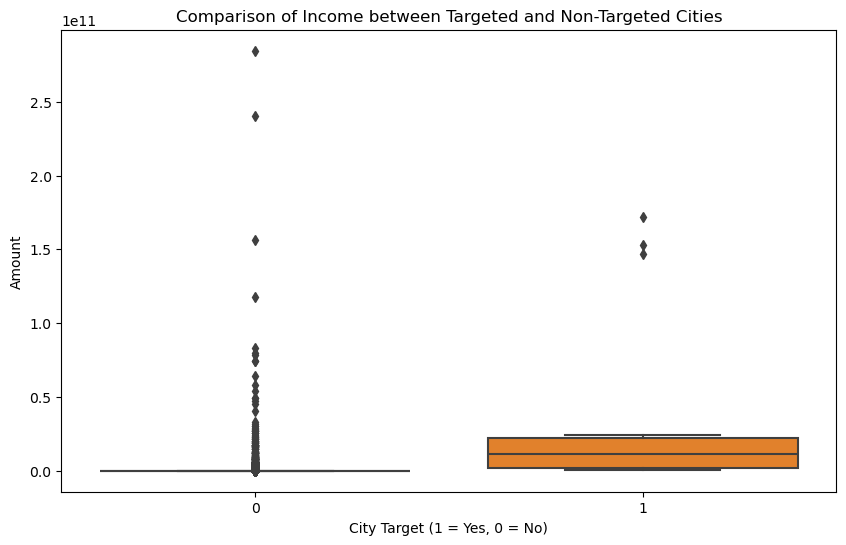

In [139]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='CITY_TARGET', y='AMOUNT', data=df_combined[df_combined['FUND_TYPE']=='INCOME_AMT'])
plt.title('Comparison of Income between Targeted and Non-Targeted Cities')
plt.xlabel('City Target (1 = Yes, 0 = No)')
plt.ylabel('Amount')
plt.show()

## Financial Transparency and Accountability
### 1. How transparent are the financial activities or organizations in these cities?

In [13]:
df_filing = df_city.copy()

aggregation = {
    1: 'Required to File',
    2: 'Required to File',
    3: 'Required to File',
    4: 'Required to File',
    6: 'Not Required to File',
    7: 'Not Required to File',
    13: 'Not Required to File',
    14: 'Not Required to File',
    0: 'Not Required to File'
}

df_filing['FILING_REQ_CD'] = df_filing['FILING_REQ_CD'].map(aggregation)

df_filing_agg = df_filing.groupby(['CITY','FILING_REQ_CD'])['EIN'].count().reset_index()
df_filing_agg = df_filing_agg.sort_values(by='EIN', ascending=False)


fig = px.bar(df_filing_agg, x='CITY', y='EIN', color='FILING_REQ_CD',barmode='group')
fig.update_layout(
    title='Tax Filing Requirement Distribution by City',
    yaxis=dict(
        title='Number of Organizations'
    ),
    xaxis=dict(
        title='City'
    )
)
fig.show()

## Trends over Time
### 1. How has the growth of nonprofit organizations evolved over time in these cities?
### 2. Can we deduce historical events or trends in these cities by looking at the ruling date of organizations? How have policy changes impacted the establishment of nonprofit organizations in these cities? Can we use the nonprofit caegories to help explain this futher?
### 3. Have certain cities seen more non profit volume activity in certain years? 
### 4. How have different sectors (e.g., education, healthcare) evolved over time in terms of nonprofit establishment and funding?


In [14]:

# format ruling data type to date
df_city['RULING'] = pd.to_datetime(df_city['RULING'], format='%Y%m', errors='coerce')
df_city['RULING_YEAR'] = df_city['RULING'].dt.year

# aggregate by year
df_city_rulingyear = df_city.groupby('RULING_YEAR')['EIN'].count().reset_index()

# drop NA in preparation for resampling
df_city_rulingna = df_city.dropna(subset=['RULING'])
df_city_rulingna.set_index('RULING', inplace=True)

# aggregate by decade
df_city_decade = df_city_rulingna.resample('10AS').sum().reset_index()

# plot ruling year
fig = px.line(df_city_rulingyear, x='RULING_YEAR',y='EIN')
fig.update_layout(
    title='Number of Nonprofits in Targeted Cities by Ruling Year',
    xaxis=dict(title='Ruling Year'),
    yaxis=dict(title='Number of Nonprofits')
)
fig.show()

# plot ruling decade
fig = px.line(df_city_decade, x='RULING',y='EIN')
fig.update_layout(
    title='Number of Nonprofits in Targeted Cities by Ruling Decade',
    xaxis=dict(title='Ruling Decade'),
    yaxis=dict(title='Number of Nonprofits')
)
fig.show()

/var/folders/79/jdv69xcs22z7cyxln5rsbzzh0000gn/T/ipykernel_62355/2173577292.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/79/jdv69xcs22z7cyxln5rsbzzh0000gn/T/ipykernel_62355/2173577292.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [15]:
# drop ntee cds that are null
df_city_nteena = df_city.dropna(subset=['NTEE_CD'])

# create ntee name map
ntee_map = {
    'A': 'Arts, Culture and Humanities',
    'B': 'Education',
    'C': 'Environment',
    'D': 'Animal-Related',
    'E': 'Health Care',
    'F': 'Mental Health & Crisis Intervention',
    'G': 'Voluntary Health Associations & Medical Disciplines',
    'H': 'Medical Research',
    'I': 'Crime & Legal-Related',
    'J': 'Employment',
    'K': 'Food, Agriculture and Nutrition',
    'L': 'Housing & Shelter',
    'M': 'Public Safety, Disaster Preparedness and Relief',
    'N': 'Recreation & Sports',
    'O': 'Youth Development',
    'P': 'Human Services',
    'Q': 'International, Foreign Affairs and National Security',
    'R': 'Civil Rights, Social Action & Advocacy',
    'S': 'Community Improvement & Capacity Building',
    'T': 'Philanthropy, Voluntarism and Grantmaking Foundations',
    'U': 'Science & Technology',
    'V': 'Social Science',
    'W': 'Public & Societal Benefit',
    'X': 'Religion-Related',
    'Y': 'Mutual & Membership Benefit'
} 

# apply map
df_city_nteena['NTEE_NAME'] = df_city_nteena['NTEE_CD'].str[0].map(ntee_map)
df_city_nteena['NTEE_NAME'].head()

# group by name and count
df_nteename_groupby = df_city_nteena.groupby('NTEE_NAME')['EIN'].count().reset_index()
df_nteename_groupby = df_nteename_groupby.sort_values(by='EIN', ascending=True)
# plot group by name and count
fig = px.bar(df_nteename_groupby, x='EIN',y='NTEE_NAME')
fig.update_layout(
    title='NTEE Name Distribution',
    xaxis=dict(title='Number of Nonprofits'),
    yaxis=dict(title='NTEE Name'),
    width=1000,
    height=600,)
fig.show()

# group by city and name for env and civil rights
ntee_list = ['Environment','Civil Rights, Social Action & Advocacy']
df_env_city = df_city_nteena[df_city_nteena['NTEE_NAME'].isin(ntee_list)]
df_nteename_city_groupby = df_env_city.groupby(['CITY','NTEE_NAME'])['EIN'].count().reset_index()
df_nteename_city_groupby = df_nteename_city_groupby.sort_values(by='EIN', ascending=False)

# plot by city and name
fig = px.bar(df_nteename_city_groupby, x='CITY',y='EIN', color='NTEE_NAME',barmode='group')
fig.update_layout(
    title='NTEE Name Distribution by City',
    xaxis=dict(title='City'),
    yaxis=dict(title='Number of Nonprofits'),
    width=1000,
    height=600,)
fig.show() 


/var/folders/79/jdv69xcs22z7cyxln5rsbzzh0000gn/T/ipykernel_62355/1793794200.py:34: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [16]:
# group by ruling and name
pd.set_option('display.float_format', lambda x: '%.0f' % x)
ruling_years = [1940, 1946, 1952, 1964, 1971, 1972, 2014]
df_city_rulingname = df_city_nteena[df_city_nteena['RULING_YEAR'].isin(ruling_years)].groupby(['RULING_YEAR','NTEE_NAME'])['EIN'].count().reset_index()

# get the top 5 NTEE names by total count
top_ntee_names = df_city_rulingname.groupby('NTEE_NAME')['EIN'].sum().nlargest(5).index
df_city_rulingname = df_city_rulingname[df_city_rulingname['NTEE_NAME'].isin(top_ntee_names)]
df_city_rulingname['RULING_YEAR'] = df_city_rulingname['RULING_YEAR'].astype('int').astype('str')

# plot group by ruling and name
fig = px.bar(df_city_rulingname, x='RULING_YEAR',y='EIN', color='NTEE_NAME',barmode='group',category_orders={'RULING_YEAR': ['1940', '1946', '1952', '1964', '1971', '1972', '2014']})
fig.update_layout(
    title='NTEE Name Distribution by Ruling Years of Interest',
    xaxis=dict(title='Ruling Year'),
    yaxis=dict(title='Number of Nonprofits'),
    width=1000,
    height=600,)
fig.show()


# group by ruling and name
ntee_list = ['Environment','Civil Rights, Social Action & Advocacy']
df_city_rulingname = df_city_nteena[
    df_city_nteena['RULING_YEAR'].isin(ruling_years) & df_city_nteena['NTEE_NAME'].isin(ntee_list)
].groupby(['RULING_YEAR', 'NTEE_NAME'])['EIN'].count().reset_index()

df_city_rulingname['RULING_YEAR'] = df_city_rulingname['RULING_YEAR'].astype(int).astype('str')

# plot group by ruling and name
fig = px.bar(df_city_rulingname, x='RULING_YEAR',y='EIN', color='NTEE_NAME',barmode='group',category_orders={'RULING_YEAR': ['1940', '1946', '1952', '1964', '1971', '1972', '2014']})
fig.update_layout(
    title='Targeted NTEE Name Distribution by Ruling Years of Interest',
    xaxis=dict(title='Ruling Year'),
    yaxis=dict(title='Number of Nonprofits'),
    width=1000,
    height=600,)
fig.show()


# group by ruling and name
ntee_list = ['Environment','Civil Rights, Social Action & Advocacy']
df_city_rulingname = df_city_nteena[ df_city_nteena['NTEE_NAME'].isin(ntee_list)].groupby(['RULING_YEAR', 'NTEE_NAME'])['EIN'].count().reset_index()

#df_city_rulingname['RULING_YEAR'] = df_city_rulingname['RULING_YEAR'].astype(int).astype('str')

# plot group by ruling and name
fig = px.line(df_city_rulingname, x='RULING_YEAR',y='EIN', color='NTEE_NAME')
fig.update_layout(
    title='Targeted NTEE Name Distribution by Ruling Year',
    xaxis=dict(title='Ruling Year'),
    yaxis=dict(title='Number of Nonprofits'),
    width=1000,
    height=600,)
fig.show()

## Machine Learning Focuses
### 1. Can we segment organizations into distinct clusters based on their financial health indicators (assets, income, revenue)?
### 2. Which clusters of organizations have the highest potential impact on addressing climate change and the digital divide based on their activity codes and financial data?

In [73]:
# preprocess 
df_cluster_na = df_env_city.dropna(subset=['REVENUE_AMT'])

# isolate financial features 
features = df_cluster_na[['INCOME_AMT','ASSET_AMT','REVENUE_AMT']]
features_scaled = StandardScaler().fit_transform(features)

# Cluster
kmeans = KMeans(n_clusters=3, random_state=42)
df_cluster_na['CLUSTER_KMEANS'] = kmeans.fit_predict(features_scaled)


/Users/ameliabaier/opt/anaconda3/envs/t_up/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/var/folders/79/jdv69xcs22z7cyxln5rsbzzh0000gn/T/ipykernel_62355/1709330107.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [119]:
df_cluster_na["CLUSTER_KMEANS"] = df_cluster_na["CLUSTER_KMEANS"].astype(str)
fig = px.scatter(df_cluster_na,x='ASSET_AMT', y='INCOME_AMT', color='CLUSTER_KMEANS',color_discrete_sequence=px.colors.qualitative.G10)
fig.update_layout(
    title='Clusters of Organizations by Financial Health',
    xaxis=dict(title='Asset Amount'),
    yaxis=dict(title='Income Amount'),
    width=1000,
    height=600,)
fig.show()

/var/folders/79/jdv69xcs22z7cyxln5rsbzzh0000gn/T/ipykernel_62355/1485889741.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### Cluster analysis

In [120]:
ntee_distribution = df_cluster_na.groupby(['CLUSTER_KMEANS', 'NTEE_NAME']).size().unstack().fillna(0).reset_index()
ntee_distribution_melt = ntee_distribution.melt(id_vars=['CLUSTER_KMEANS'], value_vars=['Civil Rights, Social Action & Advocacy','Environment'], var_name='NTEE',value_name='Number of Nonprofits')
fig= px.bar(ntee_distribution_melt, x='CLUSTER_KMEANS', y='Number of Nonprofits', color='NTEE', barmode='group')
fig.update_layout(title='KMeans Clusters by NTEE Codes',
                  xaxis=dict(title='Cluster'),
                  width=1000,
    height=600,)
fig.show()

In [108]:
cluster_analysis = df_cluster_na.groupby('CLUSTER_KMEANS')[['ASSET_AMT', 'INCOME_AMT', 'REVENUE_AMT']].median().reset_index()
cluster_analysis_melt = cluster_analysis.melt(id_vars=['CLUSTER_KMEANS'], value_vars=['INCOME_AMT', 'ASSET_AMT', 'REVENUE_AMT'], var_name='FUND_TYPE', value_name='AMOUNT')

fig= px.bar(cluster_analysis_melt, x='CLUSTER_KMEANS', y='AMOUNT', color='FUND_TYPE', barmode='group')
fig.update_layout(title='KMeans Clusters by Median Funding Amount',
                  xaxis=dict(title='Cluster'),
                  yaxis=dict(title='Amount'),
                  width=1000,
    height=600,)
fig.show()

In [121]:
df_names_highfinance = df_cluster_na[(df_cluster_na['CLUSTER_KMEANS']=='1') | (df_cluster_na['CLUSTER_KMEANS']=='2')]
df_names_highfinance = df_names_highfinance[['NAME', 'CITY','NTEE_NAME']]

markdown_table = df_names_highfinance.to_markdown(index=False)

print(markdown_table)

| NAME                    | CITY       | NTEE_NAME                              |
|:------------------------|:-----------|:---------------------------------------|
| CCKC4 INC               | WICHITA    | Civil Rights, Social Action & Advocacy |
| NEW VENTURE FUND        | WASHINGTON | Environment                            |
| WORLD WILDLIFE FUND INC | WASHINGTON | Environment                            |
| AARP                    | WASHINGTON | Civil Rights, Social Action & Advocacy |
